In [8]:
from dense_nn import GaussianDenseNN  
import matplotlib.pylab as plt
import datetime
%matplotlib inline

from jax import random
import jax.numpy as np


# Demonstrating Langevin sampling of an NN
## Using the GaussianDenseNN class

### Generate test data

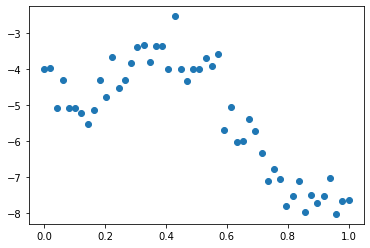

In [9]:
seed = datetime.datetime.now().microsecond
key = random.PRNGKey(seed)

N = 50
TRUE_SIGMA = 0.5
INPUTS = np.linspace(0,1, N).reshape((N,1))
#target = np.cos(inputs) + np.sin(inputs + 0.4) + random.normal(key,(N,1))*0.01
def true(x):
    return 4*np.sin(x - 2) + np.sin(8*x - 2 ) - 4*x**2
TARGET =  true(INPUTS) + random.normal(key,(N,1))*TRUE_SIGMA

plt.scatter(INPUTS, TARGET)
plt.show()

### Initialize the NN

In [10]:
nn = GaussianDenseNN(INPUTS, TARGET, (1,50,50,1), prior_weight_scale=1, prior_error_scale=1, seed=datetime.datetime.now().microsecond)

In [21]:
from time import time

In [22]:
t0 = time()
nn.get_map(nsteps=1000)
print(time() - t0)

0.0% completed. Energy = 33639.54
10.0% completed. Energy = 3839.51
20.0% completed. Energy = 3645.92
30.0% completed. Energy = 3554.46
40.0% completed. Energy = 3474.78
50.0% completed. Energy = 3404.97
60.0% completed. Energy = 3340.73
70.0% completed. Energy = 3283.96
80.0% completed. Energy = 3235.38
90.0% completed. Energy = 3192.70
100% completed. Energy = 3192.70
18.53510308265686


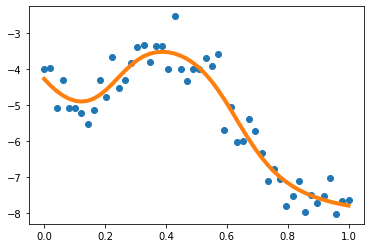

In [26]:
plt.plot(nn.inputs, nn.predict(), color='C1', lw=4)
plt.scatter(nn.inputs, nn.targets)
plt.show()

### rough burn-in

In [27]:
nsteps = 5000
save_freq = 10
percent = 10
completion_freq = int(nsteps/percent)

nn.reinit_integrator(dt=0.001, beta=1, mass=10, gamma=10)
seed = datetime.datetime.now().microsecond
key = random.PRNGKey(seed)
split_keys = random.split(key, nsteps)
t0 = time()
for i in range(nsteps):
    nn.step(key=split_keys[i])
print('Elapsed', time() - t0)

Elapsed 6.421067953109741


### production

In [28]:
mass = 1
energy = []
kinetic_energy = []
trace_sigma = []
predictions = []
params = []

In [29]:
nsteps = 100000
save_freq = 100
percent = 10
completion_freq = int(nsteps/percent)

nn.reinit_integrator(dt=0.001, beta=1, mass=mass, gamma=10)
seed = datetime.datetime.now().microsecond
key = random.PRNGKey(seed)
split_keys = random.split(key, nsteps)


start_time = time()
k=0.
for i in range(nsteps):
    nn.step(key=split_keys[i])
    if i % save_freq == 0:
        energy.append(nn.energy(nn.unknowns))
        kinetic_energy.append(np.sum(nn.momenta**2)/(2*mass))
        trace_sigma.append(nn.unknowns[0])
        predictions.append(nn.predict())
        params.append(nn.ravel(nn.unknowns[1:]))
        if nn.unknowns[0] < 0.:
            raise Exception('Sigma less than zero!')
    if i % completion_freq == 0:
        print('{0}% completed.'.format(k*percent))
        k += 1
print('100% completed.')
print('time =', time() - start_time)

0.0% completed.
10.0% completed.
20.0% completed.
30.0% completed.
40.0% completed.
50.0% completed.
60.0% completed.
70.0% completed.
80.0% completed.
90.0% completed.
100% completed.
time = 144.11231207847595


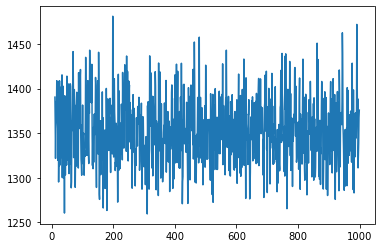

In [43]:
arr_ke = np.array(kinetic_energy)
t = np.arange(len(arr_ke))
plt.plot(t[10:], arr_ke[10:])
plt.show()

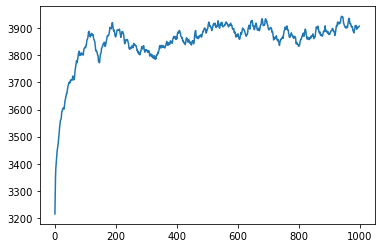

In [30]:
arr_energy = np.hstack(energy)
plt.plot(arr_energy)
plt.show()

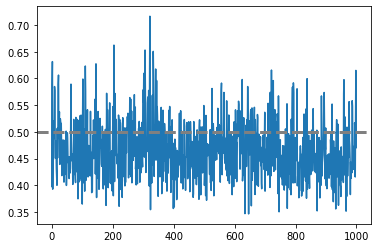

In [31]:
arr_trace_sigma = np.hstack(trace_sigma)
plt.plot(arr_trace_sigma)
plt.axhline(TRUE_SIGMA, ls='--', label='True sigma', color='grey', lw=3)
plt.show()

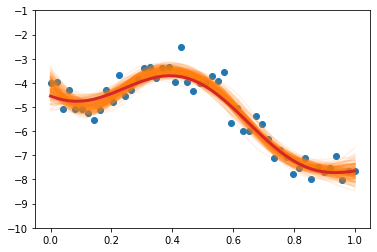

In [35]:
for i in np.arange(10, len(predictions), 5):
    plt.plot(nn.inputs, predictions[i], color='C1', alpha=0.1)
plt.scatter(INPUTS, TARGET)
plt.plot(INPUTS, true(INPUTS), color='C3', lw=3)
plt.ylim(-10,-1)
plt.show()

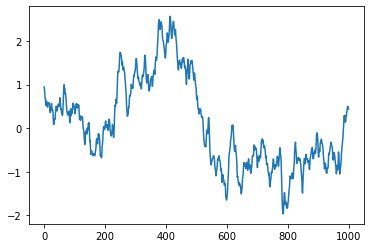

In [33]:
biases = [p[0][0][0][0] for p in params]
plt.plot(np.hstack(biases))
plt.show()